<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/bonusissue_getprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**'무상증자는 기업가치에 영향을 미칠까?'**주제에 대해 일련의 포스팅을 작성해보고자 합니다. 블로그 상단의 'Tag'를 통해 본 주제와 관련된 포스팅을 모아볼 수 있습니다.
{:.notice--warning}

## 분석대상 데이터는 어디서 오는 것일까?
무상증자는 주식시장에서 흔히 접할 수 있는 이벤트 중 하나입니다. 하지만 투자자 입장에서 무상증자가 실제로 기업가치에 어떤 영향을 미치는지, 그리고 주가에는 어떤 변화를 가져오는지 궁금하지 않으신가요? 이번 포스팅에서는 이러한 질문에 답하기 위해 데이터를 활용해 분석을 진행해 보겠습니다.<br><br>
**분석은 데이터를 통해 이뤄집니다. 그런데 데이터는 어디서 오는 것일까요?**{: style="color: #4682B4;"}
<br>
**"무상증자와 주가영향을 분석"**{: style="color: #4682B4;"}하기 위해선 아래의 그림처럼 총 3개의 출처에서 데이터를 가져와야 합니다.
<br>
![source]({{site.url}}/assets/images/2025-02-09-bonusissuegetprice/source.png)
<br>
<br>
1. **(Open DART)**{: style="color: #4682B4;"} : 무상증자 공시내역(이전에 수집한 내용)<br>
  - 종목코드는 없고, 회사명만 있음
2. **(DART 웹페이지)**{: style="color: #4682B4;"} : 회사명-종목코드 매칭 리스트<br>
  - 종목코드와 회사명이 있음
3. **(한국거래소 웹페이지)**{: style="color: #4682B4;"} : 날짜별 주가정보<br>
  - 1,2,3을 결합하면 ***무상증자 공시내역 with 종목코드*** 데이터셋이 준비됩니다


## 무상증자 공시에 종목코드 붙이기


[**지난 포스팅(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%ED%95%9C%EA%B5%AD%EC%8B%9C%EC%9E%A5/dartandkrx/)에서는 무상증자 결정공시 내역을 불러왔습니다. 이제 무상증자 공시전후 기업의 주가를 불러올 차례입니다. 그런데 그전에 먼저 기억해야 할 것이 있습니다. 현재 우리가 수집한 무상증자 공시에는 종목코드가 없습니다. 이는 앞선 포스팅에서 설명드렸듯이 DART OPENAPI가 아닌 OPENDART 웹에서 크롤링을 했을 때 생기는 한계입니다.
### 필요한 파이썬 설정하기

In [ ]:
#-----------------------------------------------------------
#필요한 패키지 import
#-----------------------------------------------------------
import pandas as pd
import requests
from time import sleep
from tqdm import tqdm
from datetime import timedelta
from io import BytesIO
import numpy as np
from tqdm.notebook import tqdm
import warnings

# 구글 드라이브 마운트(이전에 다운받은 공시내역을 불러오기 위함)
from google.colab import drive
drive.mount('/content/drive')

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

Mounted at /content/drive
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (202

### 이전에 수집한 무상증자 공시데이터 불러오기
이전에 수집했던 2015년부터 2024년까지 코스피 상장사의 무상증자 공시 데이터를 불러옵니다. 데이터는 다음과 같이 구성되어 있습니다:

In [ ]:
# CSV 파일 경로
file_path = '/content/drive/My Drive/beatenbythemarket/bonusissue.csv'

# 모든 데이터를 문자열 형태로 불러오기
bonus_issues_df = pd.read_csv(file_path, dtype=str, encoding='utf-8-sig')

# 데이터 확인
print('행 개수 : '+str(len(bonus_issues_df)))

# HTML 변환 및 커스텀 태그로 감싸기
html_table = bonus_issues_df.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

행 개수 : 140
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
      <th>발행비율</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>BGF</td>
      <td>2016-11-07</td>
      <td>24773661</td>
      <td>24773964</td>
      <td>1.0</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>2016-11-07</td>
      <td>2016</td>
      <td>0.999987769417926</td>
    </tr>
    <tr>
      <td>DL이앤씨</td>
      <td>2022-03-24</td>
      <td>19334885</td>
      <td>19358738</td>
      <td>1.0</td>
      <td>2022-04-11</td>
      <td>2022-04-28</td>
      <td>2022-03-24</td>
      <td>2022</td>
      <td>0.9987678432344091</td>
    </tr>
    <tr>
      <td>DS단석</td>
      <td>2024-11-11</td>
      <td>11722808</td>
      <td>5861404</td>
      <td>2.0</td>
      <td>202

### 금감원 기준 회사명 - 종목코드 매칭리스트 가져오기
이제 금감원 웹페이지에서 '회사명-종목코드' 매칭 리스트를 불러올 차례입니다. 금감원의 DART홈페이지에 가면 [**기업개황(링크)**{: style="color: #4682B4;"}](https://dart.fss.or.kr/dsae001/main.do)가 있습니다. 여기에서 코스피 및 코스닥 종목의 회사명과 종목코드를 엑셀로 다운받는 절차를 수행합니다.

In [ ]:
# openpyxl 경고 메시지 필터링
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# 유가 코스닥 시장 리스트
mkt_list = ['P', 'A']

# 비어있는 데이터프레임 생성
df_list_dart = pd.DataFrame()

# 코스피 및 코스닥 별로 엑셀 다운받아서 합치기
for i in range(len(mkt_list)):
  mkt = mkt_list[i]
  # URL 설정
  url = f'https://dart.fss.or.kr/dsae001/downloadExcel.do?startDate=&endDate=&currentPage=1&maxResults=&maxLinks=&sort=&series=&selectKey=&searchIndex=&textCrpCik=&autoSearch=true&businessCode=all&bsnRgsNo=&bsnRgsNo_1=&bsnRgsNo_2=&bsnRgsNo_3=&crpRgsNo=&textCrpNm=&corporationType={mkt}'

  # 엑셀 파일 다운로드
  response = requests.get(url)
  excel_path = "/content/상장사목록.xlsx"  # 코랩 환경에서 임시 저장 경로

  # 파일 저장
  with open(excel_path, "wb") as f:
      f.write(response.content)

  # 엑셀 파일을 데이터프레임으로 읽기
  df_loop = pd.read_excel(excel_path)

  # 시장 구분자 삽입
  df_loop['mkt'] = mkt

  # 합치기
  df_list_dart = pd.concat([df_list_dart, df_loop], axis = 0)

> ❗데이터프레임에는 종목코드가 ***숫자***로 인식되어있습니다. <br>이 경우, '0'으로 시작하는 종목코드(예: '005930')는 5,930으로 인식되므로, 종목을 식별하는 절차에서 문제가 생길 수 있습니다. 따라서 종목코드를 'str'형태로 전환하고 앞에 0을 채워넣습니다.

In [ ]:
# 종목코드 열을 str 타입으로 변환하고 0으로 채우기 (예: 6자리)
if '종목코드' in df_list_dart.columns:
    df_list_dart['종목코드'] = df_list_dart['종목코드'].astype(str).str.zfill(6)

#print(df_list_dart.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_list_dart.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>종목코드</th>
      <th>mkt</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>AJ네트웍스</td>
      <td>095570</td>
      <td>P</td>
    </tr>
    <tr>
      <td>AK홀딩스</td>
      <td>006840</td>
      <td>P</td>
    </tr>
    <tr>
      <td>BGF</td>
      <td>027410</td>
      <td>P</td>
    </tr>
    <tr>
      <td>BGF리테일</td>
      <td>282330</td>
      <td>P</td>
    </tr>
    <tr>
      <td>BNK금융지주</td>
      <td>138930</td>
      <td>P</td>
    </tr>
  </tbody>
</table>


### 무상증자 공시에 종목코드를 결합하기
이제 아래 내용이 준비되었습니다!
* 무상증자 결정공시
* 금감원기준 회사명과 종목코드 매칭리스트

이 둘을 결합하여, "무상증자 정보 **with 종목코드**{: style="color: #4682B4;"}"를 만들도록 하겠습니다.

In [ ]:
bonus_issues_df2 = pd.merge(bonus_issues_df, df_list_dart[['회사명','종목코드']], on='회사명', how='left')
#print(bonus_issues_df2.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = bonus_issues_df2.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
      <th>발행비율</th>
      <th>종목코드</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>BGF</td>
      <td>2016-11-07</td>
      <td>24773661</td>
      <td>24773964</td>
      <td>1.0</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>2016-11-07</td>
      <td>2016</td>
      <td>0.999987769417926</td>
      <td>027410</td>
    </tr>
    <tr>
      <td>DL이앤씨</td>
      <td>2022-03-24</td>
      <td>19334885</td>
      <td>19358738</td>
      <td>1.0</td>
      <td>2022-04-11</td>
      <td>2022-04-28</td>
      <td>2022-03-24</td>
      <td>2022</td>
      <td>0.9987678432344091</td>
      <td>375500</td>
    </tr>
    <tr>
      <td>DS단석</td>
      <td>2024-11-11</td>
      <td>11722808</td>
  

마침내 주가 크롤링을 할 준비가 되었습니다!

In [ ]:
# 혹시 결합이 안된 건이 있을지 확인
if len(bonus_issues_df2[bonus_issues_df2.종목코드.isna()]) == 0:
  print('없음')
else:
  bonus_issues_df2[bonus_issues_df2.종목코드.isna()]

없음


## 어느 기간동안의 시장반응을 관찰할 것인가?
### 주가 반응 관찰: 이사회 결의일 기준
무상증자가 발표되면 시장은 어떻게 반응할까요? 이를 분석하기 위해 이사회 결의일을 기준으로 다양한 기간 동안의 주가 변동률을 계산했습니다.<br>
> 왜 **이사회결의일**인지? <br>공시가 이사회결의일에 시장에 처음 알려지기 때문에, 주가변동을 관찰하기 위한 기준일로 적합하기 때문입니다.

<br>이사회결의일을 기준으로 아래와 같이 time span을 설정해보았습니다. 이를 통해 단기 및 중기적인 시장 반응을 모두 살펴볼 수 있습니다.


* 이사회결의일 당일 주가변동률
* 이사회결의일 전후 3일 주가변동률
* 이사회결의일 전후15일 주가변동률
* 이사회결의일 이후 3일 주가변동률
* 이사회결의일 이후 15일 주가변동률


<br>

> **영업일 기준? 달력 기준?**<br>
휴일 등이 있는 경우 전후 기간이 달라지기 때문에 **'영업일 기준'**으로 주가변동률을 구하는 것으로 진행하였습니다.<br>

<br>

> **영업일을 구하는 방법은?**
1. 한국거래소의 개장일을 구해와서 적용한다.
2. 일단 충분한 calendar days로 주가를 불러온 다음, 이사회 결정일 전후 행(row)개수를 적용하여 불러온다.

<br>
⇒ 1번 방법은 추가적인 크롤링이 필요하므로, **2번 방법**으로 진행해 보기로 합니다. 전후 50일 정도면 충분하겠죠?


In [ ]:
#전후50일
bonus_issues_df2['before50'] = pd.to_datetime(bonus_issues_df2.이사회결의일) - timedelta(days = 50)
bonus_issues_df2['before50'] = bonus_issues_df2.before50.apply(lambda x : x.strftime('%Y%m%d'))
bonus_issues_df2['after50'] = pd.to_datetime(bonus_issues_df2.이사회결의일) + timedelta(days = 50)
bonus_issues_df2['after50'] = bonus_issues_df2.after50.apply(lambda x : x.strftime('%Y%m%d'))

#확인하기
#print(bonus_issues_df2.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = bonus_issues_df2.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
      <th>발행비율</th>
      <th>종목코드</th>
      <th>before50</th>
      <th>after50</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>BGF</td>
      <td>2016-11-07</td>
      <td>24773661</td>
      <td>24773964</td>
      <td>1.0</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>2016-11-07</td>
      <td>2016</td>
      <td>0.999987769417926</td>
      <td>027410</td>
      <td>20160918</td>
      <td>20161227</td>
    </tr>
    <tr>
      <td>DL이앤씨</td>
      <td>2022-03-24</td>
      <td>19334885</td>
      <td>19358738</td>
      <td>1.0</td>
      <td>2022-04-11</td>
      <td>2022-04-28</td>
      <td>2022-03-24</td>
      <td>2022</td>
      <td>0.9987678432344091</td>
      <td>375500</



## 무상증자 공시 전후시점 주가를 수집하기
<br>

### 주가 수집은 어떻게 할까?
우리가 특정 종목의 주가를 확인하는 방법은 여러 가지입니다. 네이버 증권이나 구글에서 간단히 검색할 수도 있습니다. 하지만 만약 **여러 종목의 주가를, 각각 다른 특정 날짜**{: style="color: #4682B4;"}에 걸쳐 확인해야 한다면 어떨까요? 이를 손쉽게 처리하기 위해 Python을 활용한 자동화 방법을 소개합니다.

### 주가수집을 자동화해준 파이썬 패키지
시장에서는 주가를 수집하고자 하는 수요가 매우 많습니다. 그리고 필요는 발명의 어머니죠, 무료로 사용가능한 파이썬 패키지들이 존재합니다. 대표적으로는
* **financedatareader**{: style="color: #4682B4;"}
* **pykrx**{: style="color: #4682B4;"}
* **koapy**{: style="color: #4682B4;"}

등이 있습니다. 참고로 각 패키지에 대한 비교는 [**퀀트투자쿡북(링크)**{: style="color: #4682B4;"}](https://wikidocs.net/226894)에 잘 설명되어 있습니다. koapy에 대한 설명은 [**koapy Tutorial(링크)**{: style="color: #4682B4;"}](https://koapy.readthedocs.io/en/latest/notebooks/koapy-tutorial.html)에서 확인 가능합니다.

### 패키지를 안쓰고 한국거래소에서 직접 받아오기
패키지를 활용하면 편하게 사용이 가능한 장점이 있지만, 데이터의 기준이나 시점에 대해서 좀더 자신만의 기준을 가지고 싶을 수 있습니다.<br>
이 경우 주가 데이터를 생산하는 한국거래소의 웹페이지를 통해서 직접 주가를 받아오는 방법을 확인해보기로 합니다. 퀀트투자자인 이현열 님의 영상을 통해 배웠고 이를 응용한 것입니다. [**헨리의 금융MBA(링크)**{: style="color: #4682B4;"}](https://youtu.be/jz9Z_af_Khg?si=lQ1pwTov_sI3N-1n)

### KRX에서 주가 불러오는 함수 정의
패키지가 아닌 KRX에서 불러오는 방법을 보겠습니다. 만약 마우스와 키보드로 주가 데이터를 수집한다면 다음의 절차를 수행해야 합니다.

1. KRX 정보데이터시스템에 접속
2. 12003번화면(개별종목시세추이)을 열기
3. 종목코드와 검색기간 입력
4. 조회 후, CSV로 다운받기
5. CSV를 판다스 데이터프레임으로 전환하기

<br>

> **컴퓨터에 자동화를 지시할 때는 지시사항이 명확해야 합니다.**{: style="color: #4682B4;"}

'자동화'를 하기 위해선 **자동화 '지시사항'이 명확**{: style="color: #4682B4;"}해야 합니다. ***'알지? 주가 좀 긁어와줘~'***라고 말해서는 컴퓨터가 알아들을 수 없습니다.<br>
거래소의 12003번 화면(개별종목시세추이)을 보겠습니다. '특정종목'과 '특정날짜'의 주가데이터를 얻으려면 거래소 시스템에는 다음의 파라미터(**즉, 컴퓨터가 알아들을 수 있는 명확한 지시사항**{: style="color: #4682B4;"})를 알려줘야 합니다.

* 종목코드
* 종목명(KRX기준 종목명)
* 표준코드(ISIN)
* 조회기준일(시작, 종료)

<br>


❓ **표준코드와 회사명은 어디서 구하지?**<br>
우리는 종목코드는 갖고 있습니다. 따라서 종목코드를 기반으로 거래소 시스템에서 표준코드와 회사명을 불러와야 합니다.

<br>

❗**거래소에서 표준코드, 종목명을 불러옵니다.**
거래소 정보데이터시스템 화면번호 12005(전종목 기본정보)에서는 다음과 같이 전체 상장종목의 기본정보(종목코드, 표준코드, 종목명 포함)를 확인할 수 있습니다. [**헨리의 금융MBA(링크)**{: style="color: #4682B4;"}](https://youtu.be/jz9Z_af_Khg?si=lQ1pwTov_sI3N-1n) 영상을 참고하여 파이썬으로 이 화면의 내용을 판다스 데이터프레임으로 불러와 보았습니다.<br>
![example]({{site.url}}/assets/images/2025-02-09-bonusissuegetprice/12005.png)
<br>


In [ ]:
#-----------------------------------------------------------
#정보데이터시스템에서 주권표준코드 불러오는 과정
#-----------------------------------------------------------

#화면번호 12005(전종목기본정보)
#거래소 홈페이지에서 불러오기
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp = {
    'locale' : 'ko_KR',
    'mktId': 'ALL',
    'share': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01901'
    }

headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_listed = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')
df_listed['시장구분'] = df_listed['시장구분'].replace('KOSDAQ GLOBAL', 'KOSDAQ')
df_listed = df_listed.rename(columns=({'단축코드':'stock_code'}))

# 상위 5개 행만 확인
#print(df_listed.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_listed.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>표준코드</th>
      <th>stock_code</th>
      <th>한글 종목명</th>
      <th>한글 종목약명</th>
      <th>영문 종목명</th>
      <th>상장일</th>
      <th>시장구분</th>
      <th>증권구분</th>
      <th>소속부</th>
      <th>주식종류</th>
      <th>액면가</th>
      <th>상장주식수</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KR7098120009</td>
      <td>098120</td>
      <td>(주)마이크로컨텍솔루션</td>
      <td>마이크로컨텍솔</td>
      <td>Micro Contact Solution Co.,Ltd.</td>
      <td>2008/09/23</td>
      <td>KOSDAQ</td>
      <td>주권</td>
      <td>중견기업부</td>
      <td>보통주</td>
      <td>500</td>
      <td>8312766</td>
    </tr>
    <tr>
      <td>KR7009520008</td>
      <td>009520</td>
      <td>(주)포스코엠텍</td>
      <td>포스코엠텍</td>
      <td>POSCO M-TECH CO.,LTD.</td>
      <td>1997/11/10</td>
      <td>KOSDAQ</td>
      <td>주권</td>
      <td>우량기업부</td>
      <td>보통주</td>
      <td>500</td>
      <td>41642703</td>
    </tr>
    <tr>
 

<br>
종목의 기본정보를 불러왔습니다. 앞서 " '특정종목'과 '특정날짜'의 주가데이터를 얻으려면 거래소 시스템에는 다음의 파라미터(**즉, 컴퓨터가 알아들을 수 있는 명확한 지시사항**{: style="color: #4682B4;"})를 알려줘야 합니다."라고 했죠. 이제는 그 파라미터 정보가 마침내 모두 수집되었습니다! 주가를 크롤링할 준비가 완료된 것이죠!<br>
**get_price**{: style="color: #4682B4;"}라는 이름으로 주가를 불러오는 함수를 생성하도록 하겠습니다.

In [ ]:
#-----------------------------------------------------------
#정보데이터시스템에서 개별종목시세 불러오는 함수생성
#-----------------------------------------------------------

def get_price(stock_code, start_date, end_date, df_listed):

    # 입력된 종목코드를 바탕으로 표준코드와 종목명을 불러오기
    code = stock_code
    selected_row = df_listed[df_listed['stock_code'] == code]
    isin = selected_row['표준코드'].values[0]
    corp_name = selected_row['한글 종목약명'].values[0]

    #화면번호 12003(개별종목시세추이)
    #거래소 홈페이지에서 불러오기
    gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    gen_otp = {
        'locale' : 'ko_KR',
        'tboxisuCd_finder_stkisu0_0': f'{code}/{corp_name}',
        'isuCd': f'{isin}',
        'isuCd2': f'{code}',
        'codeNmisuCd_finder_stkisu0_0': f'{corp_name}',
        'param1isuCd_finder_stkisu0_0': 'ALL',
        'strtDd': f'{start_date}',
        'endDd': f'{end_date}',
        'adjStkPrc_check': 'Y',
        'adjStkPrc': '2',
        'share': '1',
        'money': '1',
        'csvxls_isNo': 'false',
        'name': 'fileDown',
        'url': 'dbms/MDC/STAT/standard/MDCSTAT01701'
        }

    headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
               'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

    down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    down_content = requests.post(down_url, {'code': otp}, headers = headers)

    df_ind_price = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

    return df_ind_price

### 주가 불러오기 함수를 실제 실행하기
위와 같이 "**get_price**{: style="color: #4682B4;"}" 함수를 각 종목별로 돌려가며 주가 데이터를 수집합니다. 그리고 그 결과물을 일부 보겠습니다.

In [ ]:
#-----------------------------------------------------------
#정보데이터시스템에서 개별종목시세 불러오는 과정 수행
#-----------------------------------------------------------

# 모든 데이터프레임을 저장할 리스트 생성
all_data = []

# 에러리스트 생성
error_list = []

# tqdm을 사용하여 진행 상태 표시
for i, row in tqdm(bonus_issues_df2.iterrows(), total=len(bonus_issues_df2), desc="Processing rows"):
    종목코드 = row['종목코드']
    접수일 = row['접수일']
    이사회결의일 = row['이사회결의일']
    before50 = row['before50']
    after50 = row['after50']
    발행비율 = row['발행비율']
    배정기준일 = row['배정기준일']
    상장예정일 = row['상장예정일']
    주당신주 = row['1주당신주']

    try:
        # 주가 데이터 수집
        df_loop = get_price(종목코드, before50, after50, df_listed)
        sleep(0.5)  # 과도한 요청 방지를 위한 대기

        # 입력된 종목코드를 바탕으로 종목명을 불러오기
        code = 종목코드
        selected_row = df_listed[df_listed['stock_code'] == code]
        corp_name = selected_row['한글 종목약명'].values[0]

        # 필요한 추가 열을 삽입
        df_loop['발행비율'] = 발행비율
        df_loop['주당신주'] = 주당신주
        df_loop['접수일'] = 접수일
        df_loop['이사회결의일'] = 이사회결의일
        df_loop['배정기준일'] = 배정기준일
        df_loop['상장예정일'] = 상장예정일
        df_loop['종목코드'] = 종목코드
        df_loop['종목약명'] = corp_name

        # 리스트에 데이터프레임 추가
        all_data.append(df_loop)
    except:
        error_list.append([발행비율, 주당신주, 접수일, 이사회결의일, 배정기준일, 상장예정일, 종목코드, before50, after50])
        pass

# 모든 데이터를 하나의 데이터프레임으로 결합
df_price_info = pd.concat(all_data, ignore_index=True)

# 에러 있는 경우 확인
print('에러개수 : '+str(len(error_list)))

Processing rows:   0%|          | 0/140 [00:00<?, ?it/s]

에러개수 : 0


In [ ]:
# 저장
df_price_info.to_csv('/content/drive/My Drive/beatenbythemarket/bonusissue_price.csv', index=False, encoding='utf-8-sig')
# 확인
#print(df_price_info.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_price_info.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>일자</th>
      <th>종가</th>
      <th>대비</th>
      <th>등락률</th>
      <th>시가</th>
      <th>고가</th>
      <th>저가</th>
      <th>거래량</th>
      <th>거래대금</th>
      <th>시가총액</th>
      <th>상장주식수</th>
      <th>발행비율</th>
      <th>주당신주</th>
      <th>접수일</th>
      <th>이사회결의일</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>종목코드</th>
      <th>종목약명</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2016/12/27</td>
      <td>81200</td>
      <td>-1600</td>
      <td>-1.93</td>
      <td>82900</td>
      <td>82900</td>
      <td>81100</td>
      <td>75182</td>
      <td>6136061600</td>
      <td>4023267150000</td>
      <td>49547625</td>
      <td>0.999987769417926</td>
      <td>1.0</td>
      <td>2016-11-07</td>
      <td>2016-11-07</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>027410</td>
      <td>BGF</td>
    </tr>
    <tr>
      <td>2016/12/26</td>
   

In [ ]:
# CSV 파일 경로
file_path = '/content/drive/My Drive/beatenbythemarket/bonusissue_price.csv'

# 모든 데이터를 문자열 형태로 불러오기
df_price_info = pd.read_csv(file_path, dtype=str, encoding='utf-8-sig')

# 데이터 확인
print('행 개수 : '+str(len(df_price_info)))
#print(df_price_info.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_price_info.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

행 개수 : 9579
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>일자</th>
      <th>종가</th>
      <th>대비</th>
      <th>등락률</th>
      <th>시가</th>
      <th>고가</th>
      <th>저가</th>
      <th>거래량</th>
      <th>거래대금</th>
      <th>시가총액</th>
      <th>상장주식수</th>
      <th>발행비율</th>
      <th>주당신주</th>
      <th>접수일</th>
      <th>이사회결의일</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>종목코드</th>
      <th>종목약명</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2016/12/27</td>
      <td>81200</td>
      <td>-1600</td>
      <td>-1.93</td>
      <td>82900</td>
      <td>82900</td>
      <td>81100</td>
      <td>75182</td>
      <td>6136061600</td>
      <td>4023267150000</td>
      <td>49547625</td>
      <td>0.999987769417926</td>
      <td>1.0</td>
      <td>2016-11-07</td>
      <td>2016-11-07</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>027410</td>
      <td>BGF</td>
    </tr>
    <tr>
      <td>2016/12

이제는 우리가 설정한 분석기간별(당일, 전후1일, 전후3일, 전후15일, 후3일, 후15일) 수익률을 계산하는 절차를 수행하겠습니다. 무상증자 공시 내역 하나당 6개의 수익률을 구하여 6개의 칼럼을 추가하는 방식입니다.

In [ ]:
#-----------------------------------------------------------
# 정보데이터시스템에서 불러온 데이터를 전처리
#-----------------------------------------------------------

# 종가 칼럼을 str에서 int로 변환
df_price_info['종가'] = df_price_info['종가'].astype(int)

# 날짜 변환
df_price_info['date'] = pd.to_datetime(df_price_info['일자'])
df_price_info.drop('일자', axis=1, inplace=True)

# 거래정지 시 시가, 고가, 저가가 0으로 표기되는 경우 종가로 대체
for col in ['시가', '고가', '저가']:
    df_price_info[col] = np.where(df_price_info[col] == 0, df_price_info['종가'], df_price_info[col])

# 이사회결의일을 datetime 형식으로 변환
df_price_info['이사회결의일'] = pd.to_datetime(df_price_info['이사회결의일'])
bonus_issues_df2['이사회결의일'] = pd.to_datetime(bonus_issues_df2['이사회결의일'])

#-----------------------------------------------------------
# 수익률 계산 함수 정의
#-----------------------------------------------------------

def calculate_returns(df_loop, decision_idx):
    """
    주어진 DataFrame (df_loop)과 이벤트 인덱스 (decision_idx)를 기준으로
    종가 수익률 계산
    (당일, 전후1일, 전후3일, 전후15일, 이후3일, 이후15일).
    """
    try:
        # 당일 수익률 계산
        if decision_idx > 0:  # 전날 데이터가 존재하는 경우에만 계산
            on_day_close = df_loop.loc[decision_idx, '종가']
            prev_day_close = df_loop.loc[decision_idx + 1, '종가']
            on_day_return = ((on_day_close - prev_day_close) / prev_day_close) * 100
        else:
            on_day_return = None

        # 전후 1일 수익률 계산
        if decision_idx > 0 and decision_idx < len(df_loop) - 1:
            minus_1_close = df_loop.loc[decision_idx + 1, '종가']
            plus_1_close = df_loop.loc[decision_idx - 1, '종가']
            three_day_return = ((plus_1_close - minus_1_close) / minus_1_close) * 100
        else:
            three_day_return = None

        # 전후 3일 수익률 계산
        if decision_idx > 2 and decision_idx < len(df_loop) - 3:
            minus_3_close = df_loop.loc[decision_idx + 3, '종가']
            plus_3_close = df_loop.loc[decision_idx - 3, '종가']
            seven_day_return = ((plus_3_close - minus_3_close) / minus_3_close) * 100
        else:
            seven_day_return = None

        # 전후 15일 수익률 계산
        if decision_idx > 14 and decision_idx < len(df_loop) - 15:
            minus_15_close = df_loop.loc[decision_idx + 15, '종가']
            plus_15_close = df_loop.loc[decision_idx - 15, '종가']
            fifteen_day_return = ((plus_15_close - minus_15_close) / minus_15_close) * 100
        else:
            fifteen_day_return = None

        # 이후 3일 수익률 계산
        if decision_idx >= 0 and decision_idx < len(df_loop) - 3:
            prev_day_close = df_loop.loc[decision_idx + 1, '종가']
            plus_3_close = df_loop.loc[decision_idx - 3, '종가']
            after_3_return = ((plus_3_close - prev_day_close) / prev_day_close) * 100
        else:
            after_3_return = None

        # 이후 15일 수익률 계산
        if decision_idx >= 0 and decision_idx < len(df_loop) - 15:
            prev_day_close = df_loop.loc[decision_idx + 1, '종가']
            plus_15_close = df_loop.loc[decision_idx - 15, '종가']
            after_15_return = ((plus_15_close - prev_day_close) / prev_day_close) * 100
        else:
            after_15_return = None

    except IndexError:  # 데이터가 부족한 경우 예외처리
        on_day_return = None
        three_day_return = None
        seven_day_return = None
        fifteen_day_return = None
        after_3_return = None
        after_15_return = None

    return on_day_return, three_day_return, seven_day_return, fifteen_day_return, after_3_return, after_15_return


#-----------------------------------------------------------
# 이벤트별 주가 수익률 계산
#-----------------------------------------------------------

# 수익률을 저장할 리스트 생성
onday = []
threedays = []
sevendays = []
fifteendays = []
after_3days = []  # 이후 3일 수익률 저장
after_15days = []  # 이후 15일 수익률 저장

# tqdm을 사용해 for문 진행 상황을 표시
for _, row in tqdm(bonus_issues_df2.iterrows(), total=len(bonus_issues_df2)):
    code = row['종목코드']
    bddd = row['이사회결의일']

    # 종목코드와 이사회결의일을 기준으로 데이터 필터링
    df_loop = df_price_info[(df_price_info['종목코드'] == code)].copy()

    # 날짜 기준 정렬 (필수)
    df_loop = df_loop.sort_values(by='date', ascending=False).reset_index(drop=True)

    # 해당 결의일의 인덱스 위치 확인
    if bddd in df_loop['date'].values:
        decision_idx = df_loop[df_loop['date'] == bddd].index[0]
    else:
        # bddd 이후 첫 번째 영업일 찾기
        later_dates = df_loop[df_loop['date'] > bddd]
        if len(later_dates) > 0:
            decision_idx = later_dates[later_dates['date'] == later_dates['date'].min()].index[0]
        else:
            decision_idx = None

    # 수익률 계산
    if decision_idx is not None:
        (on_day_return, three_day_return, seven_day_return, fifteen_day_return,
         after_3_return, after_15_return) = calculate_returns(df_loop, decision_idx)
    else:
        on_day_return, three_day_return, seven_day_return, fifteen_day_return, after_3_return, after_15_return = None, None, None, None, None, None

    # 계산 결과를 리스트에 추가
    onday.append(on_day_return)
    threedays.append(three_day_return)
    sevendays.append(seven_day_return)
    fifteendays.append(fifteen_day_return)
    after_3days.append(after_3_return)
    after_15days.append(after_15_return)

#-----------------------------------------------------------
# 결과 결합 및 열 정리
#-----------------------------------------------------------

# 계산한 수익률을 새로운 컬럼으로 추가
bonus_issues_df2['당일_수익률'] = onday
bonus_issues_df2['전후1일_수익률'] = threedays
bonus_issues_df2['전후3일_수익률'] = sevendays
bonus_issues_df2['전후15일_수익률'] = fifteendays
bonus_issues_df2['이후3일_수익률'] = after_3days
bonus_issues_df2['이후15일_수익률'] = after_15days

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
# 확인
#print(bonus_issues_df2.head().to_markdown())
# HTML 변환 및 커스텀 태그로 감싸기
html_table = bonus_issues_df2.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
      <th>발행비율</th>
      <th>종목코드</th>
      <th>before50</th>
      <th>after50</th>
      <th>당일_수익률</th>
      <th>전후1일_수익률</th>
      <th>전후3일_수익률</th>
      <th>전후15일_수익률</th>
      <th>이후3일_수익률</th>
      <th>이후15일_수익률</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>BGF</td>
      <td>2016-11-07</td>
      <td>24773661</td>
      <td>24773964</td>
      <td>1.0</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>2016-11-07</td>
      <td>2016</td>
      <td>0.999987769417926</td>
      <td>027410</td>
      <td>20160918</td>
      <td>20161227</td>
      <td>1.960740</td>
      <td>4.201427</td>
      <td>4.546177</td>
      <td>-3.129744</td>
      <td>3.081643</td>
      <td>-6.38612

## 데이터 시각화: 발행비율과 주가변동률
마지막으로, 발행비율과 주가 변동률 간의 관계를 시각화했습니다. 예를 들어 발행비율이 높아질수록 주가 변동률이 어떻게 달라지는지 확인할 수 있습니다.

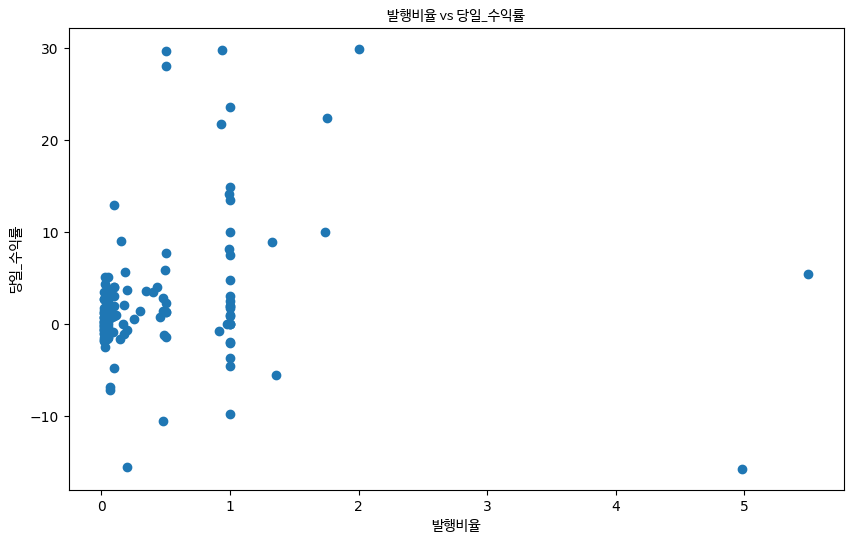

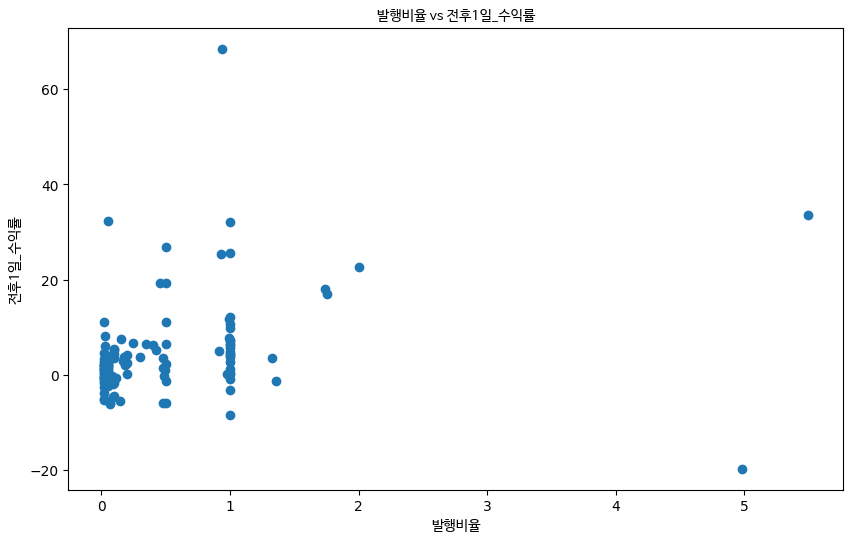

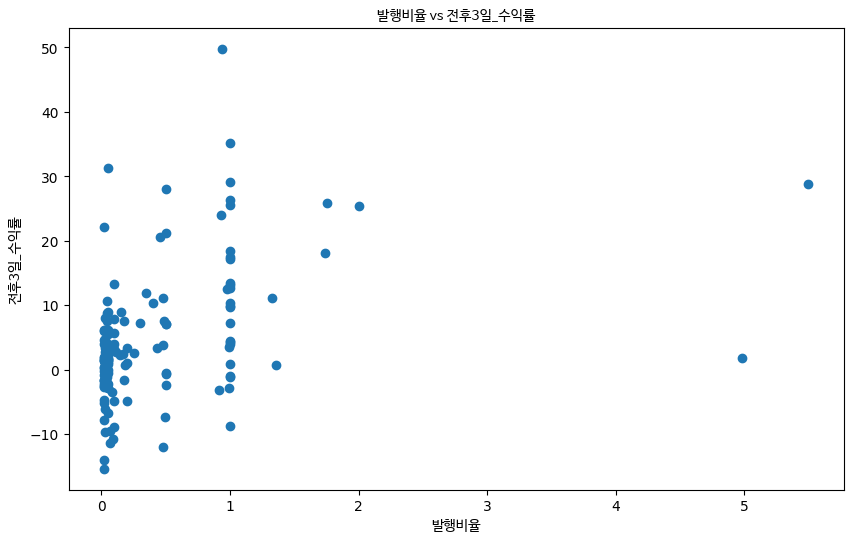

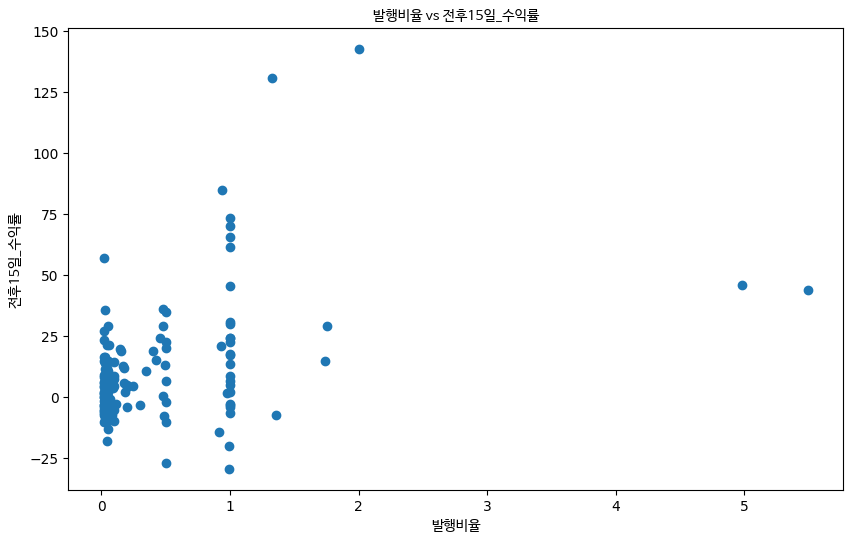

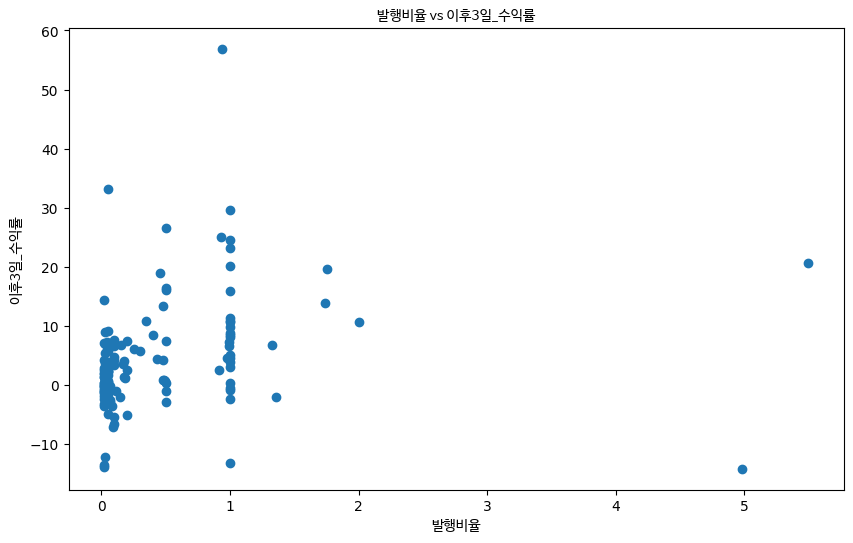

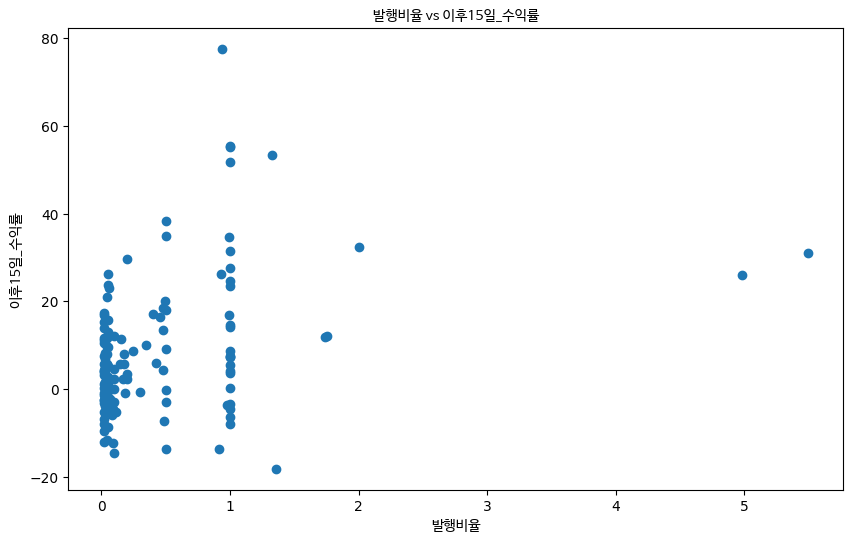

In [ ]:
# 시각화할 수익률 대상
return_types = ['당일_수익률', '전후1일_수익률', '전후3일_수익률', '전후15일_수익률', '이후3일_수익률', '이후15일_수익률']

# '발행비율'을 숫자로 변환하여 제대로 처리되도록 함
bonus_issues_df2['발행비율'] = pd.to_numeric(bonus_issues_df2['발행비율'], errors='coerce')

# 최대값 다시 계산 (NaN 값 무시)
max_val = bonus_issues_df2['발행비율'].max()

# X축 눈금 간격 변수 설정 (10%를 기준으로 설정)
tick_step = 10

# 플롯 생성 반복
for return_type in return_types:
    plt.figure(figsize=(10, 6))
    plt.scatter(bonus_issues_df2['발행비율'], bonus_issues_df2[return_type])
    plt.title(f'발행비율 vs {return_type}', fontproperties=font)
    plt.xlabel('발행비율', fontproperties=font)
    plt.ylabel(return_type, fontproperties=font)

### 극단치 제거 후 분석
발행비율이 극단적으로 높은 데이터를 제거한 후 다시 플롯을 그려보았습니다. 이는 왜곡된 결과를 방지하고 보다 신뢰할 수 있는 인사이트를 얻기 위함입니다.

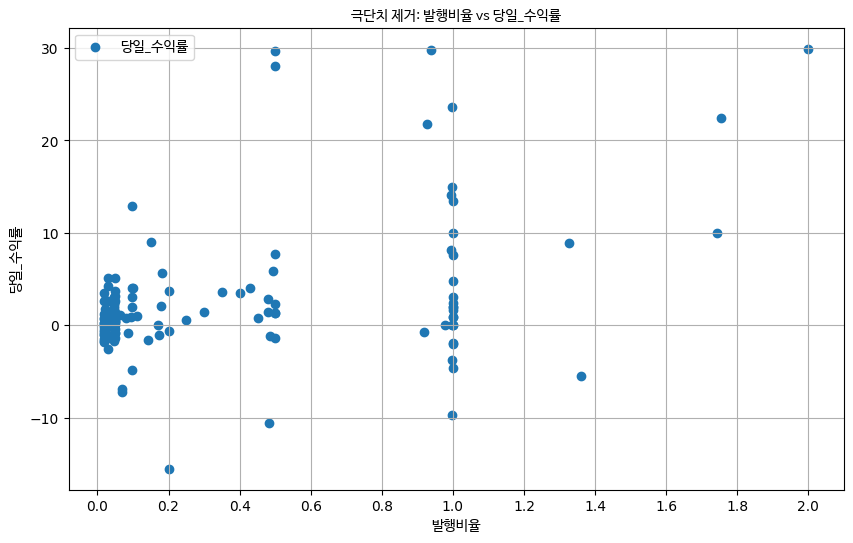

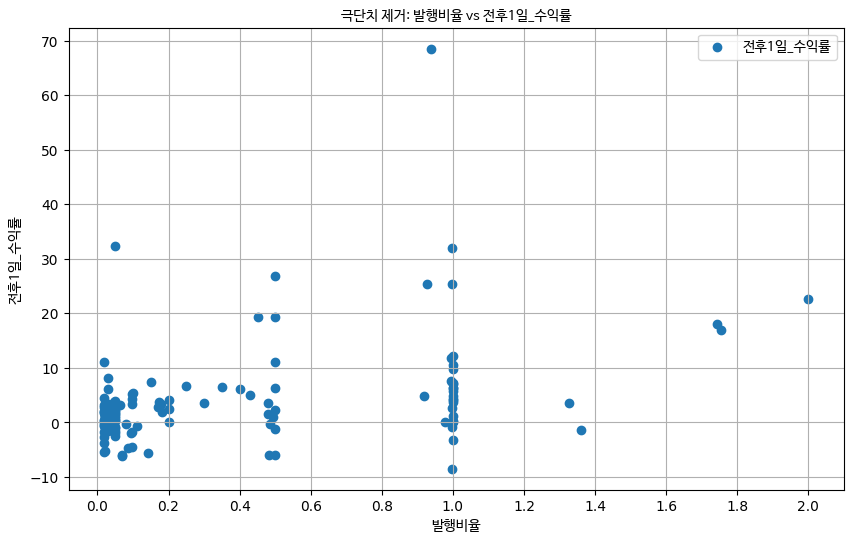

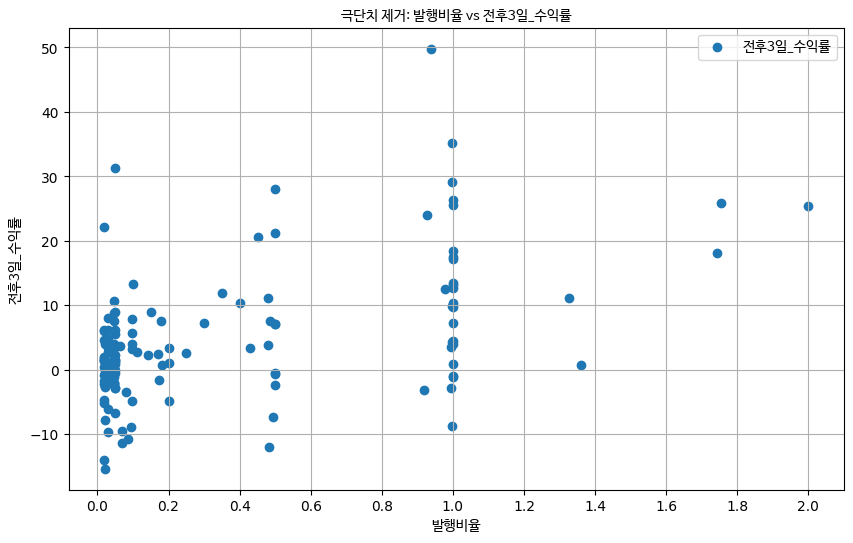

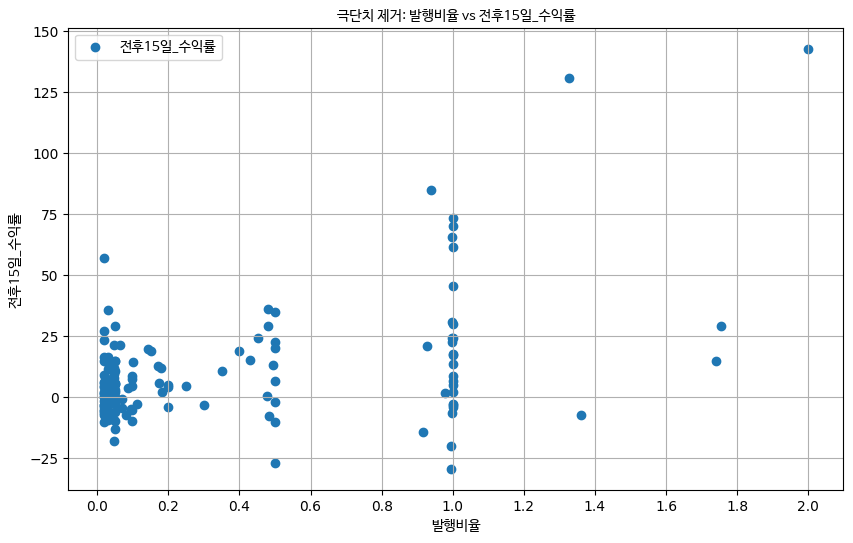

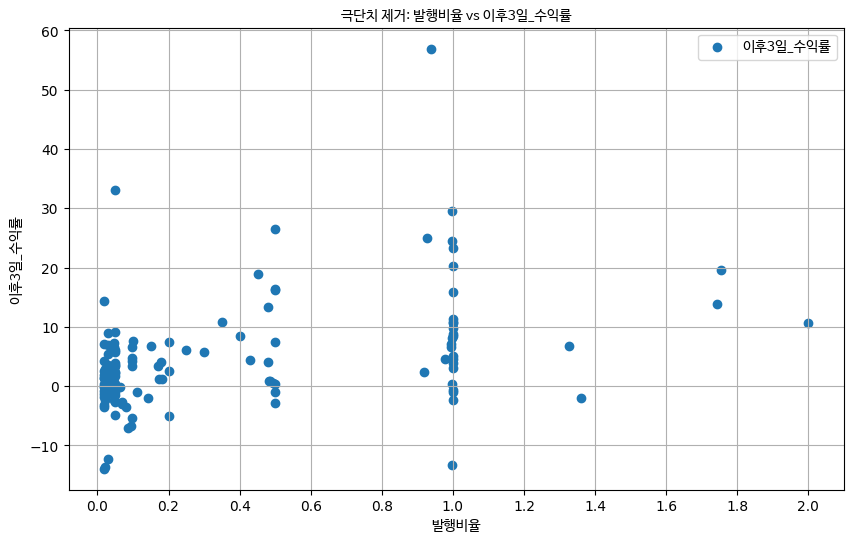

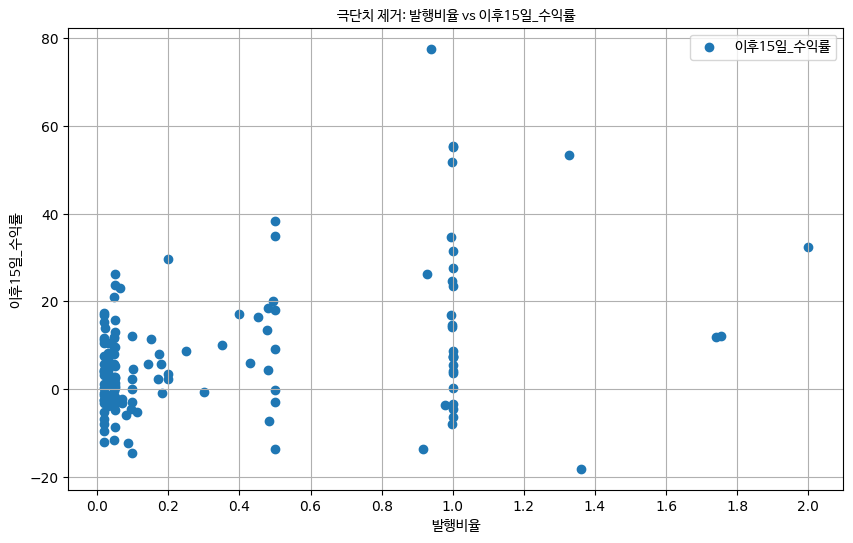

In [ ]:
# 발행비율이 2를 초과하는 극단치는 제거
filtered_df = bonus_issues_df2[bonus_issues_df2['발행비율'] <= 2]

# X축 눈금을 위한 최대값과 눈금 간격 설정 (여기서는 0.2 단위로 설정)
max_val = filtered_df['발행비율'].max()
tick_step = 0.2

for return_type in return_types:
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_df['발행비율'], filtered_df[return_type])
    plt.title(f'극단치 제거: 발행비율 vs {return_type}', fontproperties=font)
    plt.xlabel('발행비율', fontproperties=font)
    plt.ylabel(return_type, fontproperties=font)
    plt.legend([return_type], prop=font)
    plt.grid(True)
    plt.xticks(np.arange(0, max_val + tick_step, tick_step))
    plt.show()

### 추세선 확인
이번엔 단순 회귀분석 추세선을 추가하여 무상증자 비율이 주가수익률과 관계가 있는지 확인해 보겠습니다.

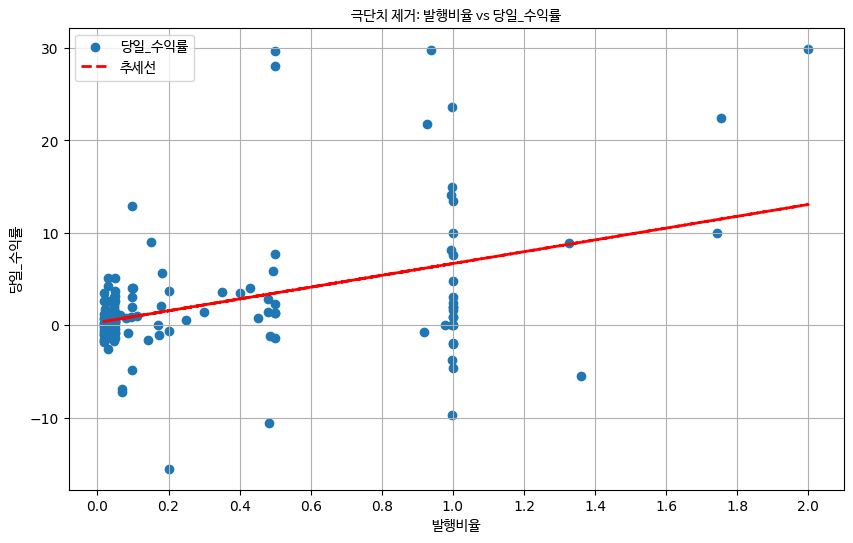

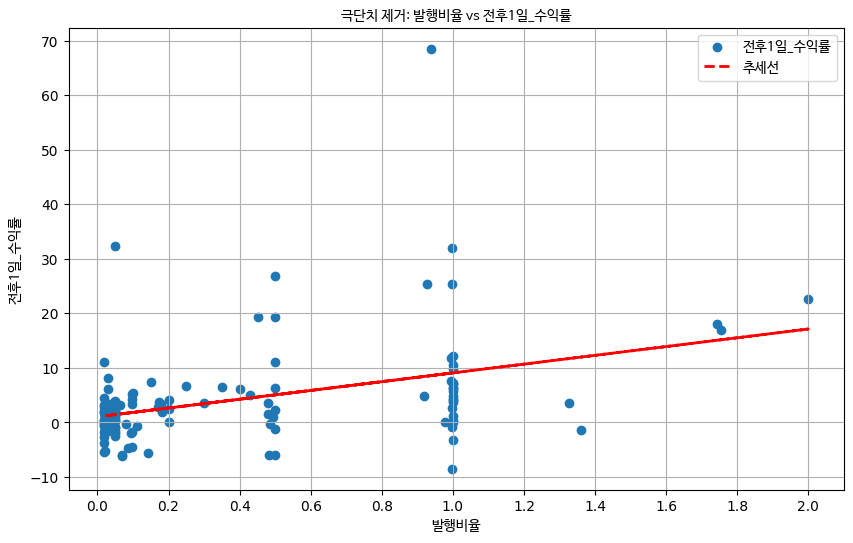

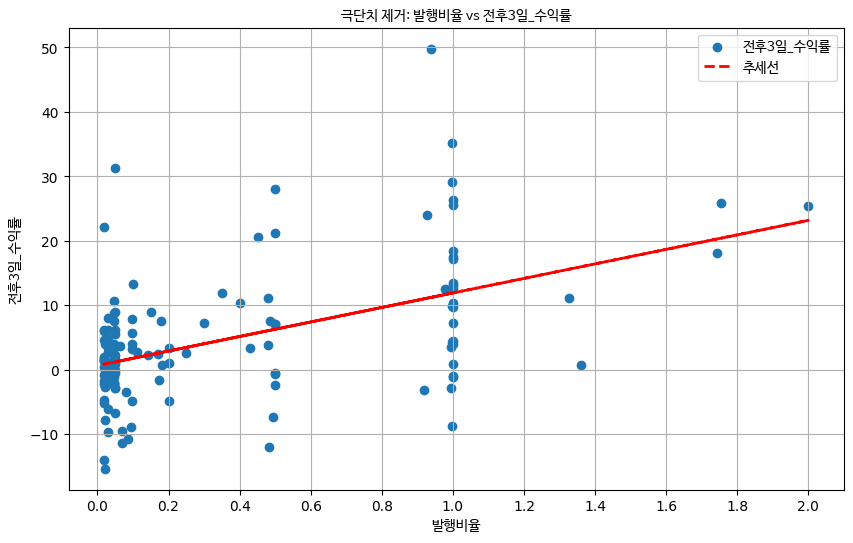

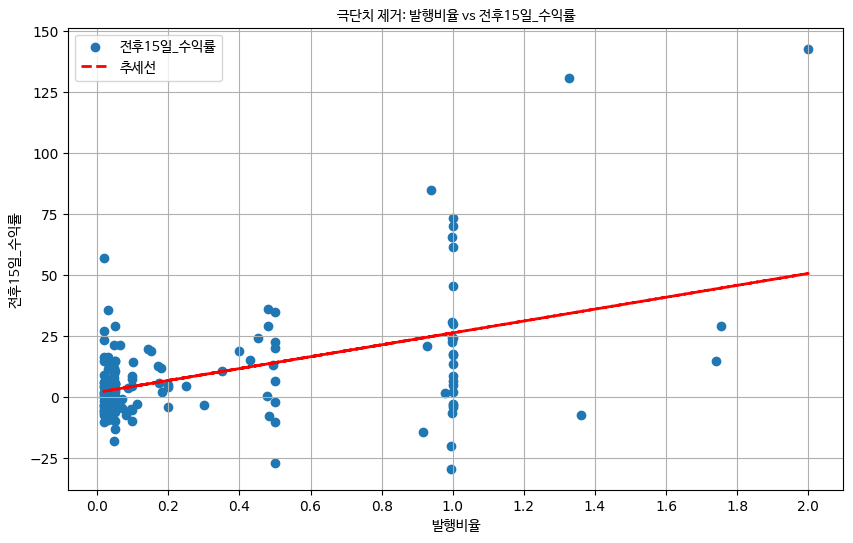

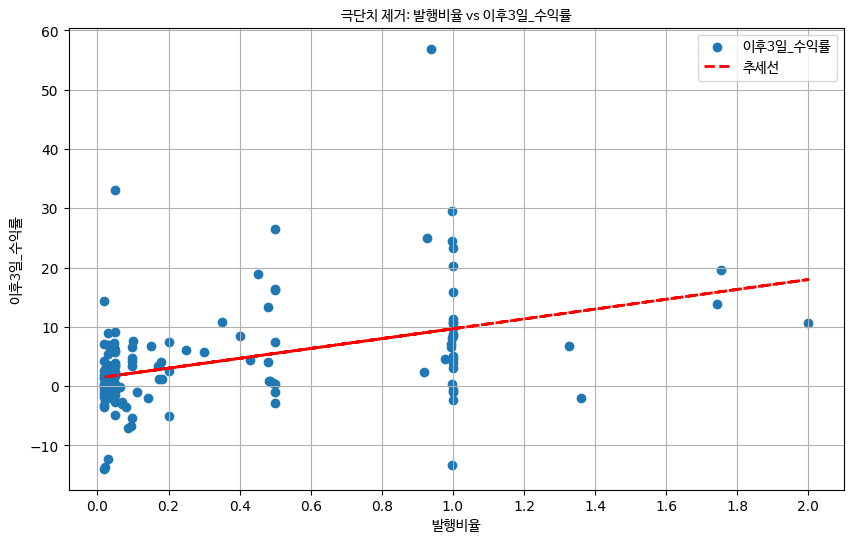

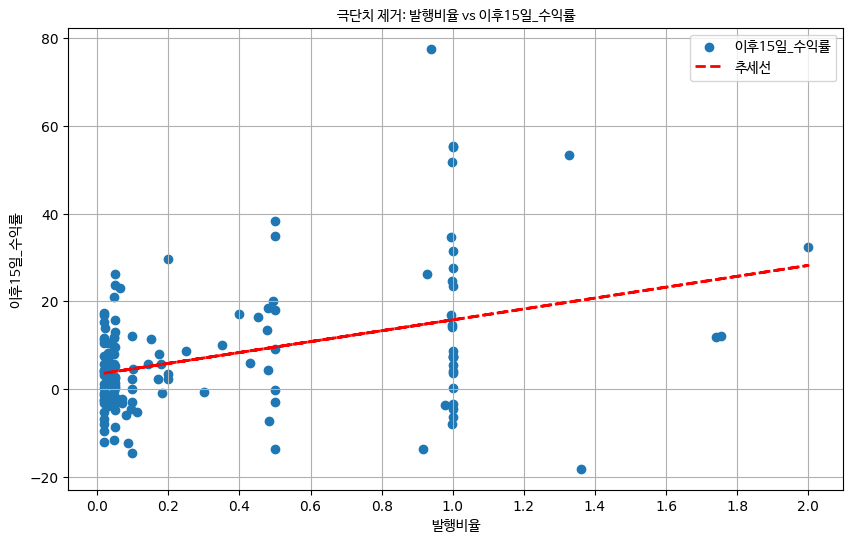

In [ ]:
# 추세선 추가
for return_type in return_types:
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_df['발행비율'], filtered_df[return_type], label=return_type)
    plt.title(f'극단치 제거: 발행비율 vs {return_type}', fontproperties=font)
    plt.xlabel('발행비율', fontproperties=font)
    plt.ylabel(return_type, fontproperties=font)
    plt.legend(prop=font)
    plt.grid(True)
    plt.xticks(np.arange(0, max_val + tick_step, tick_step))

    # 추세선 계산 및 추가
    z = np.polyfit(filtered_df['발행비율'], filtered_df[return_type], 1)  # 1차 다항식(선형) 피팅
    p = np.poly1d(z)
    plt.plot(filtered_df['발행비율'], p(filtered_df['발행비율']), color='red', linewidth=2, linestyle='--', label='추세선')

    plt.legend(prop=font)
    plt.show()


'일단은' 추세는 우상향하긴 하네요... <br>
여기까지 무상증자가 시장에 미치는 영향을 데이터로 탐구해 보았습니다. 더 자세한 분석은 다음 포스팅에서 다뤄보겠습니다!